In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
import time
#import PSNR
#import numpy

In [2]:
filename = os.listdir('./data')
filename

['baboon.raw', 'lena.raw', 'Noisy.raw', 'F16.raw']

In [3]:
all_img = []
all_1Dimg = []
for i in filename:
    raw = np.fromfile(os.path.join('./data', i), dtype='uint8')
    all_img.append(raw.reshape(512,512))
    all_1Dimg.append(raw)

In [4]:
# 0：normal, 1：uniform
def add_noise(distribution,img):
    noisy = []
    mean,var = img.mean(), img.var()
    if distribution==0:
        noise = np.random.normal(mean, var, img.shape)
    else:
        noise = np.random.uniform(0, 100, img.shape)
    n = img + noise
    # avoid going over bounds
    n[n > 255] = 255
    n[n < 0] = 0
    n = np.array(n).astype(np.uint8)
    #n = n.reshape(512,512)
    return n

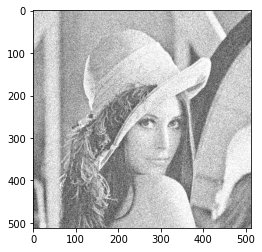

In [5]:
noisy = add_noise(1, all_img[1])
plt.imshow(noisy, cmap='gray')

In [6]:
import torch.nn as nn

In [34]:
class BM3D(nn.Module):
    def __init__(self):
        super(BM3D, self).__init__()
        self.sigma = 25
        self.Threshold_Hard3D = 2.7*self.sigma           # Threshold for Hard Thresholding
        self.First_Match_threshold = 2500             # 用于计算block之间相似度的阈值
        self.Step1_max_matched_cnt = 16              # 组最大匹配的块数
        self.Step1_Blk_Size = 8                     # block_Size即块的大小，8*8
        self.Step1_Blk_Step = 3                      # Rather than sliding by one pixel to every next reference block, use a step of Nstep pixels in both horizontal and vertical directions.
        self.Step1_Search_Step = 3                   # 块的搜索step
        self.Step1_Search_Window = 39                # Search for candidate matching blocks in a local neighborhood of restricted size NS*NS centered

        self.Second_Match_threshold = 400           # 用于计算block之间相似度的阈值
        self.Step2_max_matched_cnt = 32
        self.Step2_Blk_Size = 8
        self.Step2_Blk_Step = 3
        self.Step2_Search_Step = 3
        self.Step2_Search_Window = 39

        self.Beta_Kaiser = 2.0
        
        sigma = 25
        Threshold_Hard3D = 2.7*sigma           # Threshold for Hard Thresholding
        First_Match_threshold = 2500             # 用于计算block之间相似度的阈值
        Step1_max_matched_cnt = 16              # 组最大匹配的块数
        Step1_Blk_Size = 8                     # block_Size即块的大小，8*8
        Step1_Blk_Step = 3                      # Rather than sliding by one pixel to every next reference block, use a step of Nstep pixels in both horizontal and vertical directions.
        Step1_Search_Step = 3                   # 块的搜索step
        Step1_Search_Window = 39                # Search for candidate matching blocks in a local neighborhood of restricted size NS*NS centered

        Second_Match_threshold = 400           # 用于计算block之间相似度的阈值
        Step2_max_matched_cnt = 32
        Step2_Blk_Size = 8
        Step2_Blk_Step = 3
        Step2_Search_Step = 3
        Step2_Search_Window = 39

        Beta_Kaiser = 2.0

    
    def init(self, img, _blk_size, _Beta_Kaiser):
        """该函数用于初始化，返回用于记录过滤后图像以及权重的数组,还有构造凯撒窗"""
        m_shape = img.shape
        m_img = np.matrix(np.zeros(m_shape, dtype=float))
        m_wight = np.matrix(np.zeros(m_shape, dtype=float))
        K = np.matrix(np.kaiser(_blk_size, _Beta_Kaiser))
        m_Kaiser = np.array(K.T * K)            # 构造一个凯撒窗
        return m_img, m_wight, m_Kaiser


    def Locate_blk(self, i, j, blk_step, block_Size, width, height):
        '''该函数用于保证当前的blk不超出图像范围'''
        if i*blk_step+block_Size < width:
            point_x = i*blk_step
        else:
            point_x = width - block_Size

        if j*blk_step+block_Size < height:
            point_y = j*blk_step
        else:
            point_y = height - block_Size

        m_blockPoint = np.array((point_x, point_y), dtype=int)  # 当前参考图像的顶点

        return m_blockPoint


    def Define_SearchWindow(self, _noisyImg, _BlockPoint, _WindowSize, Blk_Size):
        """该函数返回一个二元组（x,y）,用以界定_Search_Window顶点坐标"""
        point_x = _BlockPoint[0]  # 当前坐标
        point_y = _BlockPoint[1]  # 当前坐标

        # 获得SearchWindow四个顶点的坐标
        LX = point_x+Blk_Size/2-_WindowSize/2     # 左上x
        LY = point_y+Blk_Size/2-_WindowSize/2     # 左上y
        RX = LX+_WindowSize                       # 右下x
        RY = LY+_WindowSize                       # 右下y

        # 判断一下是否越界
        if LX < 0:   LX = 0
        elif RX > _noisyImg.shape[0]:   LX = _noisyImg.shape[0]-_WindowSize
        if LY < 0:   LY = 0
        elif RY > _noisyImg.shape[0]:   LY = _noisyImg.shape[0]-_WindowSize

        return np.array((LX, LY), dtype=int)


    def Step1_fast_match(self, _noisyImg, _BlockPoint):
        """快速匹配"""
        '''
        *返回邻域内寻找和当前_block相似度最高的几个block,返回的数组中包含本身
        *_noisyImg:噪声图像
        *_BlockPoint:当前block的坐标及大小
        '''
        (present_x, present_y) = _BlockPoint  # 当前坐标
        Blk_Size = self.Step1_Blk_Size
        Search_Step = self.Step1_Search_Step
        Threshold = self.First_Match_threshold
        max_matched = self.Step1_max_matched_cnt
        Window_size = self.Step1_Search_Window

        blk_positions = np.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
        Final_similar_blocks = np.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)

        img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
        dct_img = cv2.dct(img.astype(np.float64))  # 对目标作block作二维余弦变换

        Final_similar_blocks[0, :, :] = dct_img
        blk_positions[0, :] = _BlockPoint

        Window_location = self.Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
        blk_num = (Window_size-Blk_Size)/Search_Step  # 确定最多可以找到多少相似blk
        blk_num = int(blk_num)
        (present_x, present_y) = Window_location

        similar_blocks = np.zeros((blk_num**2, Blk_Size, Blk_Size), dtype=float)
        m_Blkpositions = np.zeros((blk_num**2, 2), dtype=int)
        Distances = np.zeros(blk_num**2, dtype=float)  # 记录各个blk与它的相似度

        # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
        matched_cnt = 0
        for i in range(blk_num):
            for j in range(blk_num):
                tem_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
                dct_Tem_img = cv2.dct(tem_img.astype(np.float64))
                m_Distance = np.linalg.norm((dct_img-dct_Tem_img))**2 / (Blk_Size**2)

                # 下面记录数据自动不考虑自身(因为已经记录)
                if m_Distance < Threshold and m_Distance > 0:  # 说明找到了一块符合要求的
                    similar_blocks[matched_cnt, :, :] = dct_Tem_img
                    m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                    Distances[matched_cnt] = m_Distance
                    matched_cnt += 1
                present_y += Search_Step
            present_x += Search_Step
            present_y = Window_location[1]
        Distances = Distances[:matched_cnt]
        Sort = Distances.argsort()

        # 统计一下找到了多少相似的blk
        if matched_cnt < max_matched:
            Count = matched_cnt + 1
        else:
            Count = max_matched

        if Count > 0:
            for i in range(1, Count):
                Final_similar_blocks[i, :, :] = similar_blocks[Sort[i-1], :, :]
                blk_positions[i, :] = m_Blkpositions[Sort[i-1], :]
        return Final_similar_blocks, blk_positions, Count


    def Step1_3DFiltering(self, _similar_blocks):
        '''
        *3D变换及滤波处理
        *_similar_blocks:相似的一组block,这里已经是频域的表示
        *要将_similar_blocks第三维依次取出,然在频域用阈值滤波之后,再作反变换
        '''
        statis_nonzero = 0  # 非零元素个数
        m_Shape = _similar_blocks.shape

        # 下面这一段代码很耗时
        for i in range(m_Shape[1]):
            for j in range(m_Shape[2]):
                tem_Vct_Trans = cv2.dct(_similar_blocks[:, i, j])
                tem_Vct_Trans[np.abs(tem_Vct_Trans[:]) < self.Threshold_Hard3D] = 0.
                statis_nonzero += tem_Vct_Trans.nonzero()[0].size
                _similar_blocks[:, i, j] = cv2.idct(tem_Vct_Trans)[0]
        return _similar_blocks, statis_nonzero


    def Aggregation_hardthreshold(self, _similar_blocks, blk_positions, m_basic_img, m_wight_img, _nonzero_num, Count, Kaiser):
        '''
        *对3D变换及滤波后输出的stack进行加权累加,得到初步滤波的图片
        *_similar_blocks:相似的一组block,这里是频域的表示
        *对于最后的数组，乘以凯撒窗之后再输出
        '''
        _shape = _similar_blocks.shape
        if _nonzero_num < 1:
            _nonzero_num = 1
        block_wight = (1./_nonzero_num) * Kaiser
        for i in range(Count):
            point = blk_positions[i, :]
            tem_img = (1./_nonzero_num)*cv2.idct(_similar_blocks[i, :, :]) * Kaiser
            m_basic_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2]] += tem_img
            m_wight_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2]] += block_wight


    def BM3D_1st_step(self, _noisyImg):
        """第一步,基本去噪"""
        # 初始化一些参数：
        (width, height) = _noisyImg.shape   # 得到图像的长宽
        block_Size = self.Step1_Blk_Size         # 块大小
        blk_step = self.Step1_Blk_Step           # N块步长滑动
        Width_num = (width - block_Size)/blk_step
        Height_num = (height - block_Size)/blk_step

        # 初始化几个数组
        Basic_img, m_Wight, m_Kaiser = self.init(_noisyImg, self.Step1_Blk_Size, self.Beta_Kaiser)

        # 开始逐block的处理,+2是为了避免边缘上不够
        for i in range(int(Width_num+2)):
            for j in range(int(Height_num+2)):
                # m_blockPoint当前参考图像的顶点
                m_blockPoint = self.Locate_blk(i, j, blk_step, block_Size, width, height)       # 该函数用于保证当前的blk不超出图像范围
                Similar_Blks, Positions, Count = self.Step1_fast_match(_noisyImg, m_blockPoint)
                Similar_Blks, statis_nonzero = self.Step1_3DFiltering(Similar_Blks)
                self.Aggregation_hardthreshold(Similar_Blks, Positions, Basic_img, m_Wight, statis_nonzero, Count, m_Kaiser)
        Basic_img[:, :] /= m_Wight[:, :]
        basic = np.matrix(Basic_img, dtype=int)
        basic.astype(np.uint8)

        return basic


    def Step2_fast_match(self, _Basic_img, _noisyImg, _BlockPoint):
        '''
        *快速匹配算法,返回邻域内寻找和当前_block相似度最高的几个block,要同时返回basicImg和IMG
        *_Basic_img: 基础去噪之后的图像
        *_noisyImg:噪声图像
        *_BlockPoint:当前block的坐标及大小
        '''
        (present_x, present_y) = _BlockPoint  # 当前坐标
        Blk_Size = self.Step2_Blk_Size
        Threshold = self.Second_Match_threshold
        Search_Step = self.Step2_Search_Step
        max_matched = self.Step2_max_matched_cnt
        Window_size = self.Step2_Search_Window

        blk_positions = np.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
        Final_similar_blocks = np.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)
        Final_noisy_blocks = np.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)

        img = _Basic_img[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
        dct_img = cv2.dct(img.astype(np.float32))  # 对目标作block作二维余弦变换
        Final_similar_blocks[0, :, :] = dct_img

        n_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
        dct_n_img = cv2.dct(n_img.astype(np.float32))  # 对目标作block作二维余弦变换
        Final_noisy_blocks[0, :, :] = dct_n_img

        blk_positions[0, :] = _BlockPoint

        Window_location = self.Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
        blk_num = (Window_size-Blk_Size)/Search_Step  # 确定最多可以找到多少相似blk
        blk_num = int(blk_num)
        (present_x, present_y) = Window_location

        similar_blocks = np.zeros((blk_num**2, Blk_Size, Blk_Size), dtype=float)
        m_Blkpositions = np.zeros((blk_num**2, 2), dtype=int)
        Distances = np.zeros(blk_num**2, dtype=float)  # 记录各个blk与它的相似度

        # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
        matched_cnt = 0
        for i in range(blk_num):
            for j in range(blk_num):
                tem_img = _Basic_img[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
                dct_Tem_img = cv2.dct(tem_img.astype(np.float32))
                m_Distance = np.linalg.norm((dct_img-dct_Tem_img))**2 / (Blk_Size**2)

                # 下面记录数据自动不考虑自身(因为已经记录)
                if m_Distance < Threshold and m_Distance > 0:
                    similar_blocks[matched_cnt, :, :] = dct_Tem_img
                    m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                    Distances[matched_cnt] = m_Distance
                    matched_cnt += 1
                present_y += Search_Step
            present_x += Search_Step
            present_y = Window_location[1]
        Distances = Distances[:matched_cnt]
        Sort = Distances.argsort()

        # 统计一下找到了多少相似的blk
        if matched_cnt < max_matched:
            Count = matched_cnt + 1
        else:
            Count = max_matched

        if Count > 0:
            for i in range(1, Count):
                Final_similar_blocks[i, :, :] = similar_blocks[Sort[i-1], :, :]
                blk_positions[i, :] = m_Blkpositions[Sort[i-1], :]

                (present_x, present_y) = m_Blkpositions[Sort[i-1], :]
                n_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
                Final_noisy_blocks[i, :, :] = cv2.dct(n_img.astype(np.float64))

        return Final_similar_blocks, Final_noisy_blocks, blk_positions, Count


    def Step2_3DFiltering(self, _Similar_Bscs, _Similar_Imgs):
        '''
        *3D维纳变换的协同滤波
        *_similar_blocks:相似的一组block,这里是频域的表示
        *要将_similar_blocks第三维依次取出,然后作dct,在频域进行维纳滤波之后,再作反变换
        *返回的Wiener_wight用于后面Aggregation
        '''
        m_Shape = _Similar_Bscs.shape
        Wiener_wight = np.zeros((m_Shape[1], m_Shape[2]), dtype=float)

        for i in range(m_Shape[1]):
            for j in range(m_Shape[2]):
                tem_vector = _Similar_Bscs[:, i, j]
                tem_Vct_Trans = np.matrix(cv2.dct(tem_vector))
                Norm_2 = np.float64(tem_Vct_Trans.T * tem_Vct_Trans)
                m_weight = Norm_2/(Norm_2 + self.sigma**2)
                if m_weight != 0:
                    Wiener_wight[i, j] = 1./(m_weight**2 * self.sigma**2)
                # else:
                #     Wiener_wight[i, j] = 10000
                tem_vector = _Similar_Imgs[:, i, j]
                tem_Vct_Trans = m_weight * cv2.dct(tem_vector)
                _Similar_Bscs[:, i, j] = cv2.idct(tem_Vct_Trans)[0]

        return _Similar_Bscs, Wiener_wight


    def Aggregation_Wiener(self, _Similar_Blks, _Wiener_wight, blk_positions, m_basic_img, m_wight_img, Count, Kaiser):
        '''
        *对3D变换及滤波后输出的stack进行加权累加,得到初步滤波的图片
        *_similar_blocks:相似的一组block,这里是频域的表示
        *对于最后的数组，乘以凯撒窗之后再输出
        '''
        _shape = _Similar_Blks.shape
        block_wight = _Wiener_wight # * Kaiser

        for i in range(Count):
            point = blk_positions[i, :]
            tem_img = _Wiener_wight * cv2.idct(_Similar_Blks[i, :, :]) # * Kaiser
            m_basic_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2]] += tem_img
            m_wight_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2]] += block_wight


    def BM3D_2nd_step(self, _basicImg, _noisyImg):
        '''Step 2. 最终的估计: 利用基本的估计，进行改进了的分组以及协同维纳滤波'''
        # 初始化一些参数：
        (width, height) = _noisyImg.shape
        block_Size = self.Step2_Blk_Size
        blk_step = self.Step2_Blk_Step
        Width_num = (width - block_Size)/blk_step
        Height_num = (height - block_Size)/blk_step

        # 初始化几个数组
        m_img, m_Wight, m_Kaiser = self.init(_noisyImg, block_Size, self.Beta_Kaiser)

        for i in range(int(Width_num+2)):
            for j in range(int(Height_num+2)):
                m_blockPoint = self.Locate_blk(i, j, blk_step, block_Size, width, height)
                Similar_Blks, Similar_Imgs, Positions, Count = self.Step2_fast_match(_basicImg, _noisyImg, m_blockPoint)
                Similar_Blks, Wiener_wight = self.Step2_3DFiltering(Similar_Blks, Similar_Imgs)
                self.Aggregation_Wiener(Similar_Blks, Wiener_wight, Positions, m_img, m_Wight, Count, m_Kaiser)
        m_img[:, :] /= m_Wight[:, :]
        Final = np.matrix(m_img, dtype=int)
        Final.astype(np.uint8)

        return Final
    
    def BM3D(self, noisy):
        #Basic_img = self.BM3D_1st_step(noisy)    
        #Final_img = self.BM3D_2nd_step(Basic_img, noisy)
  
        plt.subplot(1,2,1)
        Basic_img = self.BM3D_1st_step(noisy)
        plt.imshow(Basic_img, cmap='gray')
        plt.title('Step1 BM3D', fontsize=10)

        plt.subplot(1,2,2)
        Final_img = self.BM3D_2nd_step(Basic_img, noisy)
        plt.imshow(Final_img, cmap='gray')
        plt.title('Final BM3D Result', fontsize=10)


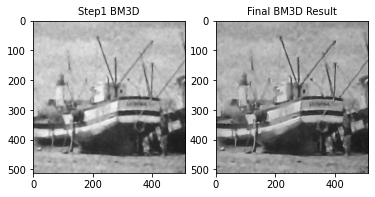

In [35]:
BM3D_model = BM3D()
BM3D_model.BM3D(all_img[2])

# try 

In [31]:
# Parameters initialization
sigma = 25
Threshold_Hard3D = 2.7*sigma           # Threshold for Hard Thresholding
First_Match_threshold = 2500             # 用于计算block之间相似度的阈值
Step1_max_matched_cnt = 16              # 组最大匹配的块数
Step1_Blk_Size = 8                     # block_Size即块的大小，8*8
Step1_Blk_Step = 3                      # Rather than sliding by one pixel to every next reference block, use a step of Nstep pixels in both horizontal and vertical directions.
Step1_Search_Step = 3                   # 块的搜索step
Step1_Search_Window = 39                # Search for candidate matching blocks in a local neighborhood of restricted size NS*NS centered

Second_Match_threshold = 400           # 用于计算block之间相似度的阈值
Step2_max_matched_cnt = 32
Step2_Blk_Size = 8
Step2_Blk_Step = 3
Step2_Search_Step = 3
Step2_Search_Window = 39

Beta_Kaiser = 2.0


def init(img, _blk_size, _Beta_Kaiser):
    """该函数用于初始化，返回用于记录过滤后图像以及权重的数组,还有构造凯撒窗"""
    m_shape = img.shape
    m_img = np.matrix(np.zeros(m_shape, dtype=float))
    m_wight = np.matrix(np.zeros(m_shape, dtype=float))
    K = np.matrix(np.kaiser(_blk_size, _Beta_Kaiser))
    m_Kaiser = np.array(K.T * K)            # 构造一个凯撒窗
    return m_img, m_wight, m_Kaiser


def Locate_blk(i, j, blk_step, block_Size, width, height):
    '''该函数用于保证当前的blk不超出图像范围'''
    if i*blk_step+block_Size < width:
        point_x = i*blk_step
    else:
        point_x = width - block_Size

    if j*blk_step+block_Size < height:
        point_y = j*blk_step
    else:
        point_y = height - block_Size

    m_blockPoint = np.array((point_x, point_y), dtype=int)  # 当前参考图像的顶点

    return m_blockPoint


def Define_SearchWindow(_noisyImg, _BlockPoint, _WindowSize, Blk_Size):
    """该函数返回一个二元组（x,y）,用以界定_Search_Window顶点坐标"""
    point_x = _BlockPoint[0]  # 当前坐标
    point_y = _BlockPoint[1]  # 当前坐标

    # 获得SearchWindow四个顶点的坐标
    LX = point_x+Blk_Size/2-_WindowSize/2     # 左上x
    LY = point_y+Blk_Size/2-_WindowSize/2     # 左上y
    RX = LX+_WindowSize                       # 右下x
    RY = LY+_WindowSize                       # 右下y

    # 判断一下是否越界
    if LX < 0:   LX = 0
    elif RX > _noisyImg.shape[0]:   LX = _noisyImg.shape[0]-_WindowSize
    if LY < 0:   LY = 0
    elif RY > _noisyImg.shape[0]:   LY = _noisyImg.shape[0]-_WindowSize

    return np.array((LX, LY), dtype=int)


def Step1_fast_match(_noisyImg, _BlockPoint):
    """快速匹配"""
    '''
    *返回邻域内寻找和当前_block相似度最高的几个block,返回的数组中包含本身
    *_noisyImg:噪声图像
    *_BlockPoint:当前block的坐标及大小
    '''
    (present_x, present_y) = _BlockPoint  # 当前坐标
    Blk_Size = Step1_Blk_Size
    Search_Step = Step1_Search_Step
    Threshold = First_Match_threshold
    max_matched = Step1_max_matched_cnt
    Window_size = Step1_Search_Window

    blk_positions = np.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
    Final_similar_blocks = np.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)

    img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
    dct_img = cv2.dct(img.astype(np.float64))  # 对目标作block作二维余弦变换

    Final_similar_blocks[0, :, :] = dct_img
    blk_positions[0, :] = _BlockPoint

    Window_location = Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
    blk_num = (Window_size-Blk_Size)/Search_Step  # 确定最多可以找到多少相似blk
    blk_num = int(blk_num)
    (present_x, present_y) = Window_location

    similar_blocks = np.zeros((blk_num**2, Blk_Size, Blk_Size), dtype=float)
    m_Blkpositions = np.zeros((blk_num**2, 2), dtype=int)
    Distances = np.zeros(blk_num**2, dtype=float)  # 记录各个blk与它的相似度

    # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
    matched_cnt = 0
    for i in range(blk_num):
        for j in range(blk_num):
            tem_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
            dct_Tem_img = cv2.dct(tem_img.astype(np.float64))
            m_Distance = np.linalg.norm((dct_img-dct_Tem_img))**2 / (Blk_Size**2)

            # 下面记录数据自动不考虑自身(因为已经记录)
            if m_Distance < Threshold and m_Distance > 0:  # 说明找到了一块符合要求的
                similar_blocks[matched_cnt, :, :] = dct_Tem_img
                m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                Distances[matched_cnt] = m_Distance
                matched_cnt += 1
            present_y += Search_Step
        present_x += Search_Step
        present_y = Window_location[1]
    Distances = Distances[:matched_cnt]
    Sort = Distances.argsort()

    # 统计一下找到了多少相似的blk
    if matched_cnt < max_matched:
        Count = matched_cnt + 1
    else:
        Count = max_matched

    if Count > 0:
        for i in range(1, Count):
            Final_similar_blocks[i, :, :] = similar_blocks[Sort[i-1], :, :]
            blk_positions[i, :] = m_Blkpositions[Sort[i-1], :]
    return Final_similar_blocks, blk_positions, Count


def Step1_3DFiltering(_similar_blocks):
    '''
    *3D变换及滤波处理
    *_similar_blocks:相似的一组block,这里已经是频域的表示
    *要将_similar_blocks第三维依次取出,然在频域用阈值滤波之后,再作反变换
    '''
    statis_nonzero = 0  # 非零元素个数
    m_Shape = _similar_blocks.shape

    # 下面这一段代码很耗时
    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            tem_Vct_Trans = cv2.dct(_similar_blocks[:, i, j])
            tem_Vct_Trans[np.abs(tem_Vct_Trans[:]) < Threshold_Hard3D] = 0.
            statis_nonzero += tem_Vct_Trans.nonzero()[0].size
            _similar_blocks[:, i, j] = cv2.idct(tem_Vct_Trans)[0]
    return _similar_blocks, statis_nonzero


def Aggregation_hardthreshold(_similar_blocks, blk_positions, m_basic_img, m_wight_img, _nonzero_num, Count, Kaiser):
    '''
    *对3D变换及滤波后输出的stack进行加权累加,得到初步滤波的图片
    *_similar_blocks:相似的一组block,这里是频域的表示
    *对于最后的数组，乘以凯撒窗之后再输出
    '''
    _shape = _similar_blocks.shape
    if _nonzero_num < 1:
        _nonzero_num = 1
    block_wight = (1./_nonzero_num) * Kaiser
    for i in range(Count):
        point = blk_positions[i, :]
        tem_img = (1./_nonzero_num)*cv2.idct(_similar_blocks[i, :, :]) * Kaiser
        m_basic_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2]] += tem_img
        m_wight_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2]] += block_wight


def BM3D_1st_step(_noisyImg):
    """第一步,基本去噪"""
    # 初始化一些参数：
    (width, height) = _noisyImg.shape   # 得到图像的长宽
    block_Size = Step1_Blk_Size         # 块大小
    blk_step = Step1_Blk_Step           # N块步长滑动
    Width_num = (width - block_Size)/blk_step
    Height_num = (height - block_Size)/blk_step

    # 初始化几个数组
    Basic_img, m_Wight, m_Kaiser = init(_noisyImg, Step1_Blk_Size, Beta_Kaiser)

    # 开始逐block的处理,+2是为了避免边缘上不够
    for i in range(int(Width_num+2)):
        for j in range(int(Height_num+2)):
            # m_blockPoint当前参考图像的顶点
            m_blockPoint = Locate_blk(i, j, blk_step, block_Size, width, height)       # 该函数用于保证当前的blk不超出图像范围
            Similar_Blks, Positions, Count = Step1_fast_match(_noisyImg, m_blockPoint)
            Similar_Blks, statis_nonzero = Step1_3DFiltering(Similar_Blks)
            Aggregation_hardthreshold(Similar_Blks, Positions, Basic_img, m_Wight, statis_nonzero, Count, m_Kaiser)
    Basic_img[:, :] /= m_Wight[:, :]
    basic = np.matrix(Basic_img, dtype=int)
    basic.astype(np.uint8)

    return basic


def Step2_fast_match(_Basic_img, _noisyImg, _BlockPoint):
    '''
    *快速匹配算法,返回邻域内寻找和当前_block相似度最高的几个block,要同时返回basicImg和IMG
    *_Basic_img: 基础去噪之后的图像
    *_noisyImg:噪声图像
    *_BlockPoint:当前block的坐标及大小
    '''
    (present_x, present_y) = _BlockPoint  # 当前坐标
    Blk_Size = Step2_Blk_Size
    Threshold = Second_Match_threshold
    Search_Step = Step2_Search_Step
    max_matched = Step2_max_matched_cnt
    Window_size = Step2_Search_Window

    blk_positions = np.zeros((max_matched, 2), dtype=int)  # 用于记录相似blk的位置
    Final_similar_blocks = np.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)
    Final_noisy_blocks = np.zeros((max_matched, Blk_Size, Blk_Size), dtype=float)

    img = _Basic_img[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
    dct_img = cv2.dct(img.astype(np.float32))  # 对目标作block作二维余弦变换
    Final_similar_blocks[0, :, :] = dct_img

    n_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
    dct_n_img = cv2.dct(n_img.astype(np.float32))  # 对目标作block作二维余弦变换
    Final_noisy_blocks[0, :, :] = dct_n_img

    blk_positions[0, :] = _BlockPoint

    Window_location = Define_SearchWindow(_noisyImg, _BlockPoint, Window_size, Blk_Size)
    blk_num = (Window_size-Blk_Size)/Search_Step  # 确定最多可以找到多少相似blk
    blk_num = int(blk_num)
    (present_x, present_y) = Window_location

    similar_blocks = np.zeros((blk_num**2, Blk_Size, Blk_Size), dtype=float)
    m_Blkpositions = np.zeros((blk_num**2, 2), dtype=int)
    Distances = np.zeros(blk_num**2, dtype=float)  # 记录各个blk与它的相似度

    # 开始在_Search_Window中搜索,初始版本先采用遍历搜索策略,这里返回最相似的几块
    matched_cnt = 0
    for i in range(blk_num):
        for j in range(blk_num):
            tem_img = _Basic_img[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
            dct_Tem_img = cv2.dct(tem_img.astype(np.float32))
            m_Distance = np.linalg.norm((dct_img-dct_Tem_img))**2 / (Blk_Size**2)

            # 下面记录数据自动不考虑自身(因为已经记录)
            if m_Distance < Threshold and m_Distance > 0:
                similar_blocks[matched_cnt, :, :] = dct_Tem_img
                m_Blkpositions[matched_cnt, :] = (present_x, present_y)
                Distances[matched_cnt] = m_Distance
                matched_cnt += 1
            present_y += Search_Step
        present_x += Search_Step
        present_y = Window_location[1]
    Distances = Distances[:matched_cnt]
    Sort = Distances.argsort()

    # 统计一下找到了多少相似的blk
    if matched_cnt < max_matched:
        Count = matched_cnt + 1
    else:
        Count = max_matched

    if Count > 0:
        for i in range(1, Count):
            Final_similar_blocks[i, :, :] = similar_blocks[Sort[i-1], :, :]
            blk_positions[i, :] = m_Blkpositions[Sort[i-1], :]

            (present_x, present_y) = m_Blkpositions[Sort[i-1], :]
            n_img = _noisyImg[present_x: present_x+Blk_Size, present_y: present_y+Blk_Size]
            Final_noisy_blocks[i, :, :] = cv2.dct(n_img.astype(np.float64))

    return Final_similar_blocks, Final_noisy_blocks, blk_positions, Count


def Step2_3DFiltering(_Similar_Bscs, _Similar_Imgs):
    '''
    *3D维纳变换的协同滤波
    *_similar_blocks:相似的一组block,这里是频域的表示
    *要将_similar_blocks第三维依次取出,然后作dct,在频域进行维纳滤波之后,再作反变换
    *返回的Wiener_wight用于后面Aggregation
    '''
    m_Shape = _Similar_Bscs.shape
    Wiener_wight = np.zeros((m_Shape[1], m_Shape[2]), dtype=float)

    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            tem_vector = _Similar_Bscs[:, i, j]
            tem_Vct_Trans = np.matrix(cv2.dct(tem_vector))
            Norm_2 = np.float64(tem_Vct_Trans.T * tem_Vct_Trans)
            m_weight = Norm_2/(Norm_2 + sigma**2)
            if m_weight != 0:
                Wiener_wight[i, j] = 1./(m_weight**2 * sigma**2)
            # else:
            #     Wiener_wight[i, j] = 10000
            tem_vector = _Similar_Imgs[:, i, j]
            tem_Vct_Trans = m_weight * cv2.dct(tem_vector)
            _Similar_Bscs[:, i, j] = cv2.idct(tem_Vct_Trans)[0]

    return _Similar_Bscs, Wiener_wight


def Aggregation_Wiener(_Similar_Blks, _Wiener_wight, blk_positions, m_basic_img, m_wight_img, Count, Kaiser):
    '''
    *对3D变换及滤波后输出的stack进行加权累加,得到初步滤波的图片
    *_similar_blocks:相似的一组block,这里是频域的表示
    *对于最后的数组，乘以凯撒窗之后再输出
    '''
    _shape = _Similar_Blks.shape
    block_wight = _Wiener_wight # * Kaiser

    for i in range(Count):
        point = blk_positions[i, :]
        tem_img = _Wiener_wight * cv2.idct(_Similar_Blks[i, :, :]) # * Kaiser
        m_basic_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2]] += tem_img
        m_wight_img[point[0]:point[0]+_shape[1], point[1]:point[1]+_shape[2]] += block_wight


def BM3D_2nd_step(_basicImg, _noisyImg):
    '''Step 2. 最终的估计: 利用基本的估计，进行改进了的分组以及协同维纳滤波'''
    # 初始化一些参数：
    (width, height) = _noisyImg.shape
    block_Size = Step2_Blk_Size
    blk_step = Step2_Blk_Step
    Width_num = (width - block_Size)/blk_step
    Height_num = (height - block_Size)/blk_step

    # 初始化几个数组
    m_img, m_Wight, m_Kaiser = init(_noisyImg, block_Size, Beta_Kaiser)

    for i in range(int(Width_num+2)):
        for j in range(int(Height_num+2)):
            m_blockPoint = Locate_blk(i, j, blk_step, block_Size, width, height)
            Similar_Blks, Similar_Imgs, Positions, Count = Step2_fast_match(_basicImg, _noisyImg, m_blockPoint)
            Similar_Blks, Wiener_wight = Step2_3DFiltering(Similar_Blks, Similar_Imgs)
            Aggregation_Wiener(Similar_Blks, Wiener_wight, Positions, m_img, m_Wight, Count, m_Kaiser)
    m_img[:, :] /= m_Wight[:, :]
    Final = np.matrix(m_img, dtype=int)
    Final.astype(np.uint8)

    return Final




time： 216.89659237861633


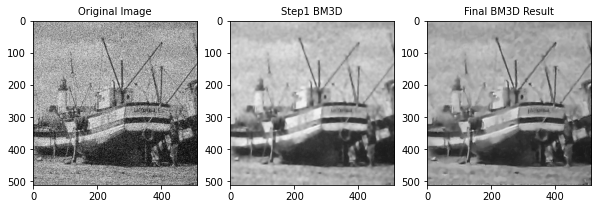

In [32]:
import time
start = time.time()
plt.figure(figsize=(10, 10))

plt.subplot(1,3,1)
plt.imshow(all_img[2], cmap='gray')
plt.title('Original Image', fontsize=10)

plt.subplot(1,3,2)
Basic_img = BM3D_1st_step(all_img[2])
plt.imshow(Basic_img, cmap='gray')
plt.title('Step1 BM3D', fontsize=10)

plt.subplot(1,3,3)
Final_img = BM3D_2nd_step(Basic_img, all_img[2])
plt.imshow(Final_img, cmap='gray')
plt.title('Final BM3D Result', fontsize=10)

end = time.time()
print('time：',end - start)

In [33]:
def BM3D(noisy): 
    Basic_img = BM3D_1st_step(noisy)    
    Final_img = BM3D_2nd_step(Basic_img, noisy)
    plt.imshow(Final_img, cmap='gray')

In [13]:
BM3D(noisy)

NameError: name 'Step1_Blk_Size' is not defined